
========== Weather Advisor Menu ==========
Please select one of the following:
1. Ask a question
2. See temperature chart
3. See rain chart
4. Get forecast summary
5. Exit
         Date  Avg Temp (°C)  Max Temp (°C)  Min Temp (°C)  Chance of Rain (%)
0  2025-05-22             21             26             15                   0
1  2025-05-23             15             17             14                 100
2  2025-05-24             15             16             14                   0


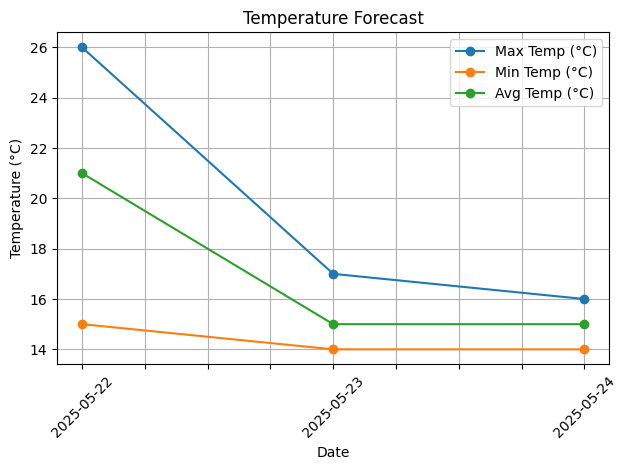


========== Weather Advisor Menu ==========
Please select one of the following:
1. Ask a question
2. See temperature chart
3. See rain chart
4. Get forecast summary
5. Exit


In [ ]:
# Setup and Configuration
!pip install pyinputplus
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import pandas as pd
import re
from datetime import datetime

# Weather Data Functions
def get_weather_data(location, forecast_days=3, as_dataframe=False):
    """
    Retrieve weather forecast data from wttr.in in JSON format.

    Parameters:
    - location (str): The location to query (e.g., 'London', 'New York').
    - forecast_days (int): Number of forecast days to return (1-3 recommended).
    - as_dataframe (bool): Return data as a pandas DataFrame if True.

    Returns:
    - dict or pd.DataFrame: Forecast weather data for the location.
    """
    if not location or not isinstance(location, str):
        raise ValueError("Location must be a non-empty string.")

    if forecast_days not in [1, 2, 3]:
        print("Note: wttr.in supports only up to 3 days of forecast.")
        forecast_days = min(max(forecast_days, 1), 3)

    url = f"https://wttr.in/{location}?format=j1"
    headers = {
        "User-Agent": "Mozilla/5.0 (WeatherApp/1.0)"
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()

        if as_dataframe:
            # Extract relevant fields
            weather_list = data.get("weather", [])[:forecast_days]
            records = []
            for day in weather_list:
                date = day.get("date", "N/A")
                avg_temp = day.get("avgtempC", "N/A")
                max_temp = day.get("maxtempC", "N/A")
                min_temp = day.get("mintempC", "N/A")
                rain_chance = day.get("hourly", [{}])[0].get("chanceofrain", "N/A")

                records.append({
                    "Date": date,
                    "Average Temp (°C)": avg_temp,
                    "Max Temp (°C)": max_temp,
                    "Min Temp (°C)": min_temp,
                    "Chance of Rain (%)": rain_chance
                })

            return pd.DataFrame(records)

        return data

    except requests.exceptions.RequestException as req_err:
        print(f"Request error: {req_err}")
    except ValueError as json_err:
        print(f"JSON decoding error: {json_err}")
    except Exception as e:
        print(f"Unexpected error: {e}")

    return None

# DataFrame Utility
def weather_to_dataframe(data, days=5):
    """
    Converts weather JSON to a Pandas DataFrame.
    """
    if not data or 'weather' not in data:
        return None

    weather_days = data['weather'][:days]
    rows = []
    for day in weather_days:
        date = day['date']
        avg_temp = int(day['avgtempC'])
        rain_chance = int(day['hourly'][0]['chanceofrain'])
        max_temp = int(day['maxtempC'])
        min_temp = int(day['mintempC'])
        rows.append({'Date': date, 'Avg Temp (°C)': avg_temp,
                     'Max Temp (°C)': max_temp, 'Min Temp (°C)': min_temp,
                     'Chance of Rain (%)': rain_chance})
    return pd.DataFrame(rows)

# Natural Language Parsing
def parse_weather_question(question):
    location = re.search(r'in ([A-Za-z\s]+)', question)
    days = re.search(r'(today|tomorrow|\d+ days?)', question)
    attribute = 'temperature' if 'temperature' in question else 'precipitation' if 'rain' in question or 'precipitation' in question else 'general'

    return {
        'location': location.group(1) if location else 'London',
        'day': days.group(1) if days else 'today',
        'attribute': attribute
    }

# Natural Language Response
def generate_weather_response(parsed, data):
    location = parsed['location']
    day = parsed['day']
    attribute = parsed['attribute']

    if not data:
        return "Sorry, I couldn't fetch the weather data."

    current = data['current_condition'][0]
    forecast = data['weather'][0]

    if attribute == 'temperature':
        temp = current['temp_C']
        return f"The current temperature in {location} is {temp}°C."
    elif attribute == 'precipitation':
        rain = forecast['hourly'][0]['chanceofrain']
        return f"The chance of rain in {location} is {rain}%."
    else:
        condition = current['weatherDesc'][0]['value']
        return f"Right now in {location}, it's {condition.lower()} with a temperature of {current['temp_C']}°C."

# Visualisation Functions
def create_temperature_visualisation(df):
    """
    Plot temperature trends (Max, Min, Average) over time.
    """
    try:
        plt.figure(figsize=(10, 6))
        ax = df.plot(
            x='Date',
            y=['Max Temp (°C)', 'Min Temp (°C)', 'Avg Temp (°C)'],
            marker='o',
            linewidth=2,
            markersize=6
        )
        plt.title("Temperature Forecast", fontsize=14)
        plt.ylabel("Temperature (°C)")
        plt.xlabel("Date")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        # Annotate values
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                ax.annotate(f"{y}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

        plt.show()
    except Exception as e:
        print(f"Error in temperature visualization: {e}")

def create_precipitation_visualisation(df):
    """
    Plot precipitation forecast as a bar chart.
    """
    try:
        plt.figure(figsize=(10, 6))
        ax = df.plot(
            x='Date',
            y='Chance of Rain (%)',
            kind='bar',
            color='skyblue',
            legend=False
        )
        plt.title("Rain Forecast", fontsize=14)
        plt.ylabel("Chance of Rain (%)")
        plt.xlabel("Date")
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Annotate bar values
        for i, bar in enumerate(ax.patches):
            height = bar.get_height()
            ax.annotate(f"{height}%", (bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)

        plt.show()
    except Exception as e:
        print(f"Error in precipitation visualization: {e}")

# Assessment Function
def weather_assessment(df, show_details=True):
    """
    Analyze a 3- to 5-day weather forecast DataFrame and print insights.

    Parameters:
    - df (pd.DataFrame): DataFrame containing weather data with the columns:
        'Date', 'Max Temp (°C)', 'Min Temp (°C)', 'Average Temp (°C)', 'Chance of Rain (%)'
    - show_details (bool): If True, prints detailed assessment.

    Returns:
    - dict: Summary containing warmest, coldest, and rainiest day information.
    """

    if df is None or df.empty:
        print("Weather data is not available for assessment.")
        return {}

    # Convert relevant columns to numeric (handles any unexpected strings)
    df['Max Temp (°C)'] = pd.to_numeric(df['Max Temp (°C)'], errors='coerce')
    df['Min Temp (°C)'] = pd.to_numeric(df['Min Temp (°C)'], errors='coerce')
    df['Average Temp (°C)'] = pd.to_numeric(df['Average Temp (°C)'], errors='coerce')
    df['Chance of Rain (%)'] = pd.to_numeric(df['Chance of Rain (%)'], errors='coerce')

    # Compute additional metric: Comfort Index (lower rain + moderate temp = better)
    df['Comfort Index'] = (100 - df['Chance of Rain (%)']) - abs(df['Average Temp (°C)'] - 22)

    warmest_day = df.loc[df['Max Temp (°C)'].idxmax()]
    coldest_day = df.loc[df['Min Temp (°C)'].idxmin()]
    rainiest_day = df.loc[df['Chance of Rain (%)'].idxmax()]
    best_day = df.loc[df['Comfort Index'].idxmax()]

    if show_details:
        print("\n  Weather Assessment Summary:")
        print(f"Warmest Day: {warmest_day['Date']} ({warmest_day['Max Temp (°C)']}°C)")
        print(f"Coldest Day: {coldest_day['Date']} ({coldest_day['Min Temp (°C)']}°C)")
        print(f"Rainiest Day: {rainiest_day['Date']} ({rainiest_day['Chance of Rain (%)']}% chance of rain)")
        print(f"Best Day for Outdoor Activity: {best_day['Date']} (Comfort Score: {best_day['Comfort Index']:.2f})")

    return {
        "Warmest Day": {
            "date": warmest_day['Date'],
            "temp": warmest_day['Max Temp (°C)']
        },
        "Coldest Day": {
            "date": coldest_day['Date'],
            "temp": coldest_day['Min Temp (°C)']
        },
        "Rainiest Day": {
            "date": rainiest_day['Date'],
            "rain_chance": rainiest_day['Chance of Rain (%)']
        },
        "Best Day": {
            "date": best_day['Date'],
            "comfort_score": round(best_day['Comfort Index'], 2)
        }
    }


# User Interface
def user_menu():
    while True:
        print("\n========== Weather Advisor Menu ==========")
        choice = pyip.inputMenu(['Ask a question', 'See temperature chart', 'See rain chart', 'Get forecast summary', 'Exit'], numbered=True)

        if choice == 'Ask a question':
            question = input("Ask a weather-related question (e.g., Will it rain in Sydney tomorrow?):\n> ")
            parsed = parse_weather_question(question)
            data = get_weather_data(parsed['location'])
            response = generate_weather_response(parsed, data)
            print(response)

        elif choice == 'See temperature chart':
            location = input("Enter location: ")
            data = get_weather_data(location)
            df = weather_to_dataframe(data)
            if df is not None:
                print(df)
                create_temperature_visualisation(df)

        elif choice == 'See rain chart':
            location = input("Enter location: ")
            data = get_weather_data(location)
            df = weather_to_dataframe(data)
            if df is not None:
                print(df)
                create_precipitation_visualisation(df)

        elif choice == 'Get forecast summary':
            location = input("Enter location: ")
            data = get_weather_data(location)
            df = weather_to_dataframe(data)
            if df is not None:
                print(df)
                weather_assessment(df)

        elif choice == 'Exit':
            print("\n What's a tornado's favourite game? Twister!!!")
            print("Good day :)")
            break

# Run the Application
if __name__ == '__main__':
    user_menu()

